In [2]:
import pickle

path = "logs/ours_normalized_param_search.pkl"
with open(path, "rb") as f:
    data = pickle.load(f)

slo_ms = data["slo_ms"]
results = data["results"]

rows = []
for lam, by_tag in results.items():
    for tag, m in by_tag.items():
        rows.append({
            "lam": lam,
            "tag": tag,
            "p95_ms": m["p95_ms"],
            "drop_ratio": m["drop_ratio"],
            "avg_exit_all": m.get("avg_exit_all", float("nan")),
        })

# 1) 过滤满足 SLO
filtered = [r for r in rows if r["p95_ms"] <= slo_ms]

# 2) 排序（先 drop_ratio，再 p95，再 avg_exit_all 反向）
filtered.sort(key=lambda r: (r["drop_ratio"], r["p95_ms"], -r["avg_exit_all"]))

print(f"number of configurations that satisfy SLO: {len(filtered)}\n")
print("Top 10 (SLO satisfied):")
for r in filtered[:10]:
    print(r)
    
# shows the min drop and key that satisfies SLO
filtered.sort(key=lambda r: r["drop_ratio"])
print(f"\nMin drop_ratio that satisfies SLO: {filtered[0]['p95_ms']} ms")
print(f"Key: lam={filtered[0]['lam']}, tag={filtered[0]['tag']}")

# shows the min p95_ms and key that satisfies SLO
filtered.sort(key=lambda r: r["p95_ms"])
print(f"\nMin p95_ms that satisfies SLO: {filtered[0]['p95_ms']} ms")
print(f"Key: lam={filtered[0]['lam']}, tag={filtered[0]['tag']}")
    

number of configurations that satisfy SLO: 3375

Top 10 (SLO satisfied):
{'lam': 110.0, 'tag': 'W_SLO_0.7_W_ACC_0.2_SLO_PENALTY_TARGET_1.4', 'p95_ms': 1.5145101409871127, 'drop_ratio': 0.0, 'avg_exit_all': 1.0000581936685289}
{'lam': 110.0, 'tag': 'W_SLO_0.9_W_ACC_0.1_SLO_PENALTY_TARGET_1.1', 'p95_ms': 1.5169860271271316, 'drop_ratio': 0.0, 'avg_exit_all': 1.0}
{'lam': 110.0, 'tag': 'W_SLO_0.2_W_ACC_0.2_SLO_PENALTY_TARGET_1.1', 'p95_ms': 1.5188409539405248, 'drop_ratio': 0.0, 'avg_exit_all': 1.0}
{'lam': 110.0, 'tag': 'W_SLO_0.3_W_ACC_0.2_SLO_PENALTY_TARGET_0.5', 'p95_ms': 1.5216851228615267, 'drop_ratio': 0.0, 'avg_exit_all': 1.0}
{'lam': 110.0, 'tag': 'W_SLO_0.8_W_ACC_0.2_SLO_PENALTY_TARGET_0.5', 'p95_ms': 1.5252849974785931, 'drop_ratio': 0.0, 'avg_exit_all': 1.0015921688878406}
{'lam': 110.0, 'tag': 'W_SLO_0.5_W_ACC_0.1_SLO_PENALTY_TARGET_0.1', 'p95_ms': 1.5253036050125945, 'drop_ratio': 0.0, 'avg_exit_all': 1.0}
{'lam': 110.0, 'tag': 'W_SLO_0.7_W_ACC_0.1_SLO_PENALTY_TARGET_0.5', '

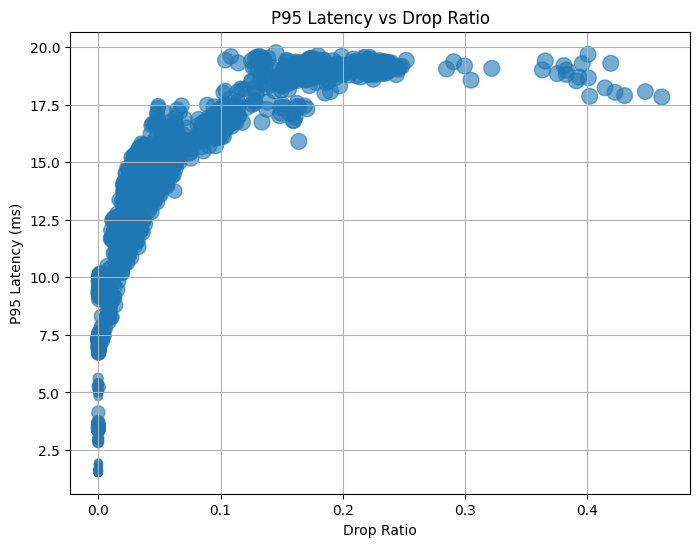

In [3]:
# draw the regression line for p95_ms vs drop_ratio
# point shows the avg_exit_all value
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
p95_ms = [r["p95_ms"] for r in rows]
drop_ratio = [r["drop_ratio"] for r in rows]
avg_exit_all = [r["avg_exit_all"] for r in rows]
max_exit = max(avg_exit_all)
min_exit = min(avg_exit_all)
avg_exit_all = [(a - min_exit) / (max_exit - min_exit) for a in avg_exit_all]  # normalize
plt.scatter(drop_ratio, p95_ms, s=[(0.3+a) * 100 for a in avg_exit_all], alpha=0.6)
plt.xlabel("Drop Ratio")
plt.ylabel("P95 Latency (ms)")
plt.title("P95 Latency vs Drop Ratio")
plt.grid(True)
plt.show()
# Fit a regression line
import numpy as np
m, b = np.polyfit(drop_ratio, p95_ms, 1)

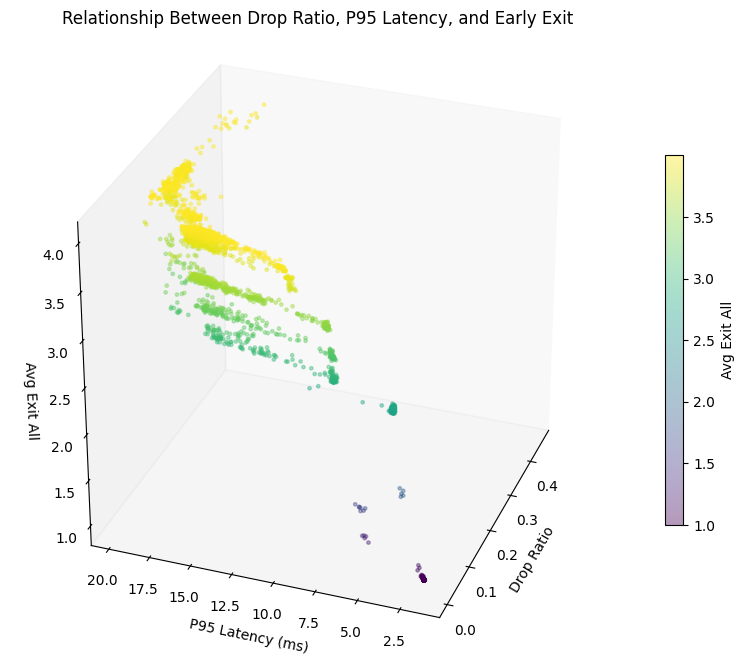

In [25]:
# plot 'p95_ms' and 'drop_ratio' and 'avg_exit_all' in 3D scatter plot
p95_ms = [r["p95_ms"] for r in rows]
drop_ratio = [r["drop_ratio"] for r in rows]
avg_exit_all = [r["avg_exit_all"] for r in rows]


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    drop_ratio,
    p95_ms,
    avg_exit_all,
    c=avg_exit_all,          # 用 z 轴编码颜色
    cmap='viridis',
    s=6,                     # 明显减小
    alpha=0.4
)

ax.set_xlabel("Drop Ratio")
ax.set_ylabel("P95 Latency (ms)")
ax.set_zlabel("Avg Exit All")

ax.set_box_aspect((1, 1, 1))    # 关键：等比例
ax.view_init(elev=30, azim=200)  # 合理视角
ax.grid(False)

plt.colorbar(sc, shrink=0.6, label="Avg Exit All")
plt.title("Relationship Between Drop Ratio, P95 Latency, and Early Exit")
# plt.show()
plt.savefig("./figures/Relationship Between Drop Ratio, P95 Latency, and Early Exit")

In [3]:
# print tag according to drop_ratio ascending, from 0 to 0.01
rows.sort(key=lambda r: r["drop_ratio"])
print("\nAll results sorted by drop_ratio:")
eligible_rows = [r for r in rows if 0 <= r["drop_ratio"] <= 0.01 and 3 <= r["avg_exit_all"]]
print(f"number of configurations with drop_ratio <= 0.01 and avg_exit_all >= 3: {len(eligible_rows)}")
for r in eligible_rows:
    print(f'drop ratio: {r["drop_ratio"]}, row:{r}')


All results sorted by drop_ratio:
number of configurations with drop_ratio <= 0.01 and avg_exit_all >= 3: 210
drop ratio: 0.00017815784785319794, row:{'lam': 110.0, 'tag': 'W_SLO_0.3_W_ACC_0.6_SLO_PENALTY_TARGET_1.4', 'p95_ms': 7.376069755991921, 'drop_ratio': 0.00017815784785319794, 'avg_exit_all': 3.457175100974103}
drop ratio: 0.00017830609212481427, row:{'lam': 110.0, 'tag': 'W_SLO_0.2_W_ACC_0.5_SLO_PENALTY_TARGET_1.2', 'p95_ms': 6.967752709169862, 'drop_ratio': 0.00017830609212481427, 'avg_exit_all': 3.155510640827488}
drop ratio: 0.00017830609212481427, row:{'lam': 110.0, 'tag': 'W_SLO_0.3_W_ACC_0.5_SLO_PENALTY_TARGET_0.7', 'p95_ms': 6.973788401228375, 'drop_ratio': 0.00017830609212481427, 'avg_exit_all': 3.1677565093330164}
drop ratio: 0.000178359096313912, row:{'lam': 110.0, 'tag': 'W_SLO_0.6_W_ACC_0.5_SLO_PENALTY_TARGET_1.1', 'p95_ms': 6.896849197801202, 'drop_ratio': 0.000178359096313912, 'avg_exit_all': 3.1563299042635427}
drop ratio: 0.0001791044776119403, row:{'lam': 110.

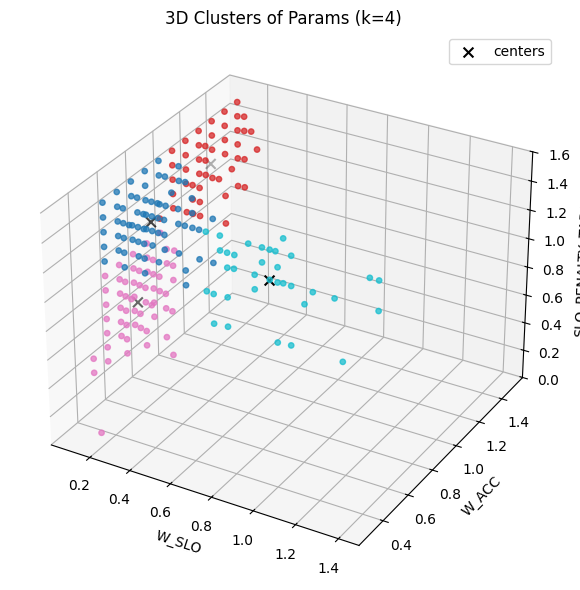

In [4]:
# draw the parameters cluster plot
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
params = []
for r in eligible_rows:
    tag =  r["tag"]
    param_values = []
    for x in tag.split('_'):
        try:
            x = float(x)
            param_values.append(x)
        except:
            pass
    params.append(param_values)
# test
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = np.array(params)
if X.ndim != 2 or X.shape[1] != 3:
    raise ValueError(f"Expected params to be (N, 3), got {X.shape}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# pick k by silhouette score
best_k = 3
best_score = -1
for k in range(2, min(8, len(X))):
    km = KMeans(n_clusters=k, n_init=10, random_state=0)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    if score > best_score:
        best_k = k
        best_score = score

km = KMeans(n_clusters=best_k, n_init=10, random_state=0)
labels = km.fit_predict(X_scaled)
centers = scaler.inverse_transform(km.cluster_centers_)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='tab10', s=15, alpha=0.75)
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='black', s=50, marker='x', label='centers')
ax.set_xlabel('W_SLO')
ax.set_ylabel('W_ACC')
ax.set_zlabel('SLO_PENALTY_TARGET')
ax.set_title(f'3D Clusters of Params (k={best_k})')
ax.legend()
plt.tight_layout()
plt.show()

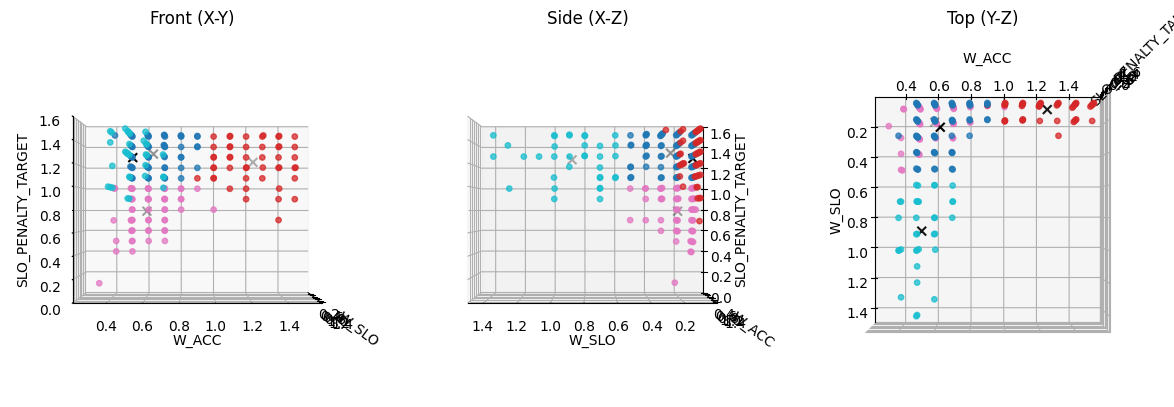

In [5]:
# three-view plot from orthogonal directions
fig = plt.figure(figsize=(12, 4))
views = [
    (0, 0, 'Front (X-Y)'),
    (0, 90, 'Side (X-Z)'),
    (90, 0, 'Top (Y-Z)'),
]
for i, (elev, azim, title) in enumerate(views, start=1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='tab10', s=15, alpha=0.75)
    ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='black', s=40, marker='x')
    ax.set_xlabel('W_SLO')
    ax.set_ylabel('W_ACC')
    ax.set_zlabel('SLO_PENALTY_TARGET')
    ax.set_title(title)
    ax.view_init(elev=elev, azim=azim)
plt.tight_layout()
plt.show()


In [6]:
# 打印每个中心点的参数值
for i, c in enumerate(centers):
    print(f"cluster {i} center:", c)

# 找到每个中心点最近的配置
import numpy as np

nearest = []
for i, c in enumerate(centers):
    d = np.linalg.norm(X - c, axis=1)
    idx = int(np.argmin(d))
    nearest.append((i, eligible_rows[idx]["tag"], X[idx]))

for i, tag, vals in nearest:
    print(f"cluster {i} nearest tag: {tag}, params: {vals}")
    for r in eligible_rows:
        if r["tag"] == tag:
            print("corresponding result:\n", r)
            break

cluster 0 center: [0.24264706 0.63235294 1.32647059]
cluster 1 center: [0.13125    1.24166667 1.25208333]
cluster 2 center: [0.19491525 0.59152542 0.78474576]
cluster 3 center: [0.88285714 0.52571429 1.26857143]
cluster 0 nearest tag: W_SLO_0.2_W_ACC_0.6_SLO_PENALTY_TARGET_1.3, params: [0.2 0.6 1.3]
corresponding result:
 {'lam': 110.0, 'tag': 'W_SLO_0.2_W_ACC_0.6_SLO_PENALTY_TARGET_1.3', 'p95_ms': 7.330646447371691, 'drop_ratio': 0.0008395298632765651, 'avg_exit_all': 3.4660304885367905}
cluster 1 nearest tag: W_SLO_0.1_W_ACC_1.2_SLO_PENALTY_TARGET_1.3, params: [0.1 1.2 1.3]
corresponding result:
 {'lam': 110.0, 'tag': 'W_SLO_0.1_W_ACC_1.2_SLO_PENALTY_TARGET_1.3', 'p95_ms': 9.949834474537049, 'drop_ratio': 0.0012891128559709363, 'avg_exit_all': 3.9869748885238208}
cluster 2 nearest tag: W_SLO_0.2_W_ACC_0.6_SLO_PENALTY_TARGET_0.7, params: [0.2 0.6 0.7]
corresponding result:
 {'lam': 110.0, 'tag': 'W_SLO_0.2_W_ACC_0.6_SLO_PENALTY_TARGET_0.7', 'p95_ms': 7.304790707712525, 'drop_ratio': 0

In [7]:
tag_o= 'W_SLO_1_W_ACC_0.3_SLO_PENALTY_TARGET_1.2'
for r in rows:
    if r["tag"] == tag_o:
        print("corresponding result:\n", r)

corresponding result:
 {'lam': 110.0, 'tag': 'W_SLO_1_W_ACC_0.3_SLO_PENALTY_TARGET_1.2', 'p95_ms': 3.5445032524876265, 'drop_ratio': 0.0, 'avg_exit_all': 2.783582089552239}


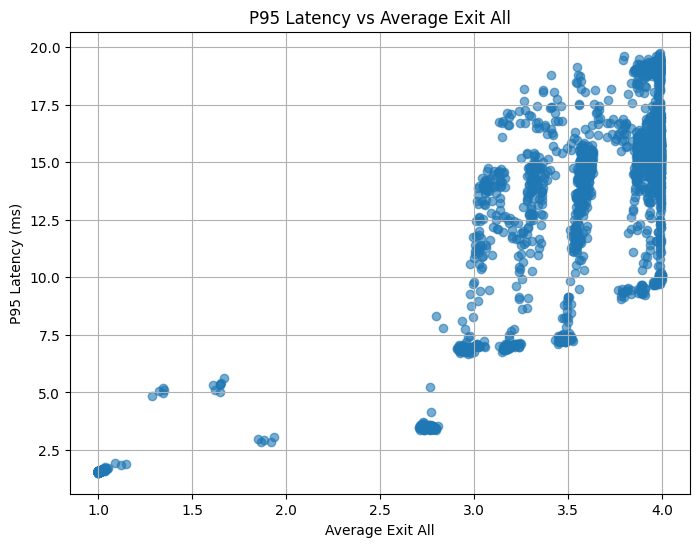

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
running_time = [r["p95_ms"] for r in rows]
avg_exit_all = [r["avg_exit_all"] for r in rows]
plt.scatter(avg_exit_all, running_time, alpha=0.6)
plt.xlabel("Average Exit All")
plt.ylabel("P95 Latency (ms)")
plt.title("P95 Latency vs Average Exit All")
plt.grid(True)
plt.show()
# Fit a regression line